# Groundwater Flow

## Bernoulli's Equation
<p>Bernoulli's equation is an equation that describes the energy that a fluid has. The energy of a fluid can be contained in kinetic energy, gravitation potential energy, and pressure energy: </p>
<h3><center>$E = \frac{1}{2}mv^{2} + mgz + P$</center></h3>
<p>This equation is also used in modelling the flow of water through an aquifer. By dividing each term by $m$ and $g$, the equation for <b>hydraulic head</b> is obtained: </p>
<h3><center>$h = \frac{v^{2}}{2g} + z + \frac{P}{\rho g}$</center></h3>
<p>Where $h$ is the <b>hydraulic head</b>, given in units of length. In the ground, the water flows so slowly that the velocity term is negligible, and can therefore be taken away. In the equation, each of the terms on the right side of the equation are referred to as the <b>velocity head</b>, <b>elevation head</b>, and <b>pressure head</b>. The equation that I use for my equations is then:</p>
<h3><center>$h = h_{z} + h_{P} = z + \frac{P}{\rho g}$</center></h3>
<p>Hydraulic head is described in terms of a <b>datum</b>, and is therefore relative. The differences between head at points does NOT change, however. By this equation, it is shown that if the water is at hydrostatic equilibrium, the head is equal at any point in it. Additionally, for an unconfined aquifer, the pressure at the top of the aquifer is equal to atmosphereic pressure, which is set to zero. Hydraulic head can be measured using a piezometer.</p>
<p>The pressure head can be calculated by rearranging this equation: </p>
<h3><center>$P = \rho g(h - z)$</center></h3>

In [1]:
def calculateHydraulicHead(z, P):
    '''
    Calculates the hydraulic head for a given elevation and pressure.
    '''
    return z + P/(1000 * 9.81)

def calculatePressureHead(h, z):
    '''
    Calculates the pressure head for a given hydraulic
    head and elevation head
    '''
    return (9810)*(h - z)

## Darcy's Law
<p><b>Darcy's law</b> is the central equation that I use in this library. It describes the flow of groundwater between two points in terms of the head gradient between the two points and scaled by the <b>hydraulic conductivity</b>, which is a property of the medium through which the water passes, and represents the ease by which water can flow through it. Coarse grained materials like sand and gravel have high conductivities, while fine-grained materials like silt and clay have quite low values. Darcy's equation: </p>
<h3><center>$Q = KA \frac{dh}{dL}$ </center></h3>
<p>Where $Q$ is the discharge passing through the two points, $K$ is the hydraulic conductivity, $A$ is the area that water flows through, $dh$ is the difference in head between the two points, and $dL$ is the distance between the two points.</p>
<p>Dividing this equation by $A$ normalizes it to be discharge per unit area:</p>
<h3><center>$q = -K \frac{dh}{dL}$</center></h3>
<p>Where $q$ is the <b>specific discharge</b> or <b>Darcy velocity</b>, but does not actually represent a real velocity. In order to determine the average velocity of the flow, divide Darcy velocity by <b>porosity</b> (the ratio of void to total space in the medium): </p>
<h3><center>$\bar{u} = \frac{q}{\theta}$</center></h3>
<p>Since porosity is ALWAYS less than or equal to 1, the average velocity of the groundwater flow will ALWAYS be greater than or equal to Darcy velocity.</p>


In [1]:
def dischargeDarcy(K, length, width, h1, h2, L):
    '''
    returns the discharge. 
    -K is hydraulic conductivity
    -Length and width are the dimensions of the flow area
    -h1 and h2 are the hydraulic head values
    -L is the distance between the two points
    '''
    return K*A*(h2-h1)/L

def specificDischarge(K, h1, h2, L):
    '''
    Returns the specific discharge (Darcy velocity)
    '''
    return (K/L)*(h2-h1)

def avgVelocity(q, theta):
    '''
    Returns the average velocity of flow given a Darcy velocity and porosity
    '''
    return q/theta

## A new formulation
<p>Despite being very simple to understand, these forms of Darcy's Law are not very useful for a large discretized model. In my model, I use a grid of square or rectangular prisms. I cannot simulate flow in every direction, so instead I simulate it by determining the flow on all 4 sides of the cube. With a model that is sufficiently discretized and taken with a sufficiently small time step, this function simulates radial flow quite well, with boxes that fall very near a given circle radius having nearly identical hydraulic head values, after some time. In my model, I use a temporary variable called the <b>queue</b> that stores the water discharge values so that they cannot affect the model later.</p>
<p>This function assumes that the boundaries of the aquifer are impermeable. Therefore, the values must be calculated as if there is no flow at the boundaries, so the calculation must be split up into sections that deal with each corner, each edge exluding the corner, and the interior region.</p>

In [1]:
def getQueue(heads):
    '''
    Calculates the queue for a given head array.
    It assumes that the boundaries of the aquifer are impermeable.
    '''
    # First, define the queue
    queue = np.zeros(heads.shape)
    
    # Determine the difference in all 4 directions
    queue[:-1,:] += heads[1: ,:] - heads[:-1,:]   # Top side
    queue[1: ,:] += heads[:-1,:] - heads[1: ,:]   # Bottom side
    queue[:,:-1] += heads[:,1: ] - heads[:,:-1]   # Left side
    queue[:,1: ] += heads[:,:-1] - heads[:,1: ]   # Right side
    
    return queue

def discharge2D(heads, conductivity, heights, scaleX = 1, scaleY = 1):
    '''
    Determines the net discharge for each point on the grid.
    -Uses the heads at a the points on the grid. to determine dh
    -Use a scaling factor that relates the dimensions of the blocks in either
        direction to calculate dL
    -This function is more general and uses heterogeneous (but isotropic) conductivity,
        as well as grid spaces with different sizes.
    -Requires an array of flow area heights
    '''
    
    # Calculate the queue
    queue = np.zeros(heads.shape)
    queue[:-1,:] += (heads[1: ,:] - heads[:-1,:])*conductivity[:-1,:]*heights[:-1,:]*(1/scaleY)  #need to multiply by area
    queue[1: ,:] += (heads[:-1,:] - heads[1: ,:])*conductivity[1: ,:]*heights[1: ,:]*(1/scaleY)
    queue[:,:-1] += (heads[:,1: ] - heads[:,:-1])*conductivity[:,:-1]*heights[:,:-1]*(1/scaleX)
    queue[:,1: ] += (heads[:,:-1] - heads[:,1: ])*conductivity[:,1: ]*heights[:,1: ]*(1/scaleX)
    
    # Update heads
    heads += queue
    
    # Delete queue
    del queue
    
    return heads

<p>This function is SIGNIFICANTLY smaller compared to the implementation in both C++ and CUDA. In those versions, the function is ~70 lines with numerous for loops and boolean statements. While this version is much slower, it is much less intimidating. Another aspect that makes the C++ and CUDA versions much more complicated is that they usea 1D array instead of a 2D one. So, determining location is a bit more complicated, but makes the function ~2x faster. But the C++ version is not about about readability, the Python version is. To put it into perspective, this Python version can calculate a 1024x1024 queue at a rate of ~12 times per second. The CUDA version, however, can do the same task at ~7,000 times per second on my NVidia GeForce 1650 with 892 CUDA cores.</p>
<p>The second equation is a more complete version of the groundwater flow function. This new function takes into account the x and y scale of the unit cells. For each direction (up, down, left, and right), the individual discharge is calculated in a single expression and then added to the queue. The calculation time for a single run of the 1024x1024 rate is ~.25 seconds.</p>

## Specific Storage and Storativity
### Specific Storage
<p>In the function above, we have a function to determine the rate that water flows through the a cell, but that does not tell how the hydraulic head in an adjacent cell will change according to the flow of water. To do that, use <b>specific storage</b>, which is a measure of how hydraulic head relates to water volume within a unit. <b>Specific storage</b> is defined as the decrease in volume of water per volume of aquifer. The equation defining specific storage is:</p>
<h3><center>$S = -\frac{dV_{w}}{V_{t}} \frac{1}{dh} $ </center></h3>
<br>

### Storativity
<p><b>Storativity</b> is related to specific storage in that it represents the volume of water expelled by a unit <u>surface area</u>. Specific storage $S_{s}$ and storativity $S$ are related by:</p>
<h3><center>$ S = S_{s} b$</center></h3>
<p>Where $b$ is the thickness of the aquifer. The equation for determining how the hydraulic head changes due to a volume of water is:</p>
<h3><center>$ dV_{w} = -SAdh$</center></h3>
<p>Expanding $dh$ and rearranging terms gives the final value of hydraulic head after a volume of water has flowed out.</p>
<h3><center>$dV_{w} = -SA(h_{f} - h_{i})$ <br> $h_{f} - h_{i} = \frac{dV_{w}}{-SA} $ <br> $h_{f} = h_{i} - \frac{dV_{w}}{SA}$ </center></h3>
<p>In to finish off the groundwater flow function, we need to define $dV_{w}$. Volumetric discharge ($Q$) is defined as the change in volume over time:</p>
<h3><center>$Q = \frac{V}{t}$ <br> $V = Qt$</center></h3>
<p>Using this equation, the the volume of water flowing that flows for an arbitrary time $t$ can be determined. Now, the full groundwater flow equation can be written.</p>

In [40]:
def updateHeads2D(heads, conductivity, heights, Ss, timeStep = 1, scaleX = 1, scaleY = 1):
    '''
    Determines the net discharge for each point on the grid.
    -Uses the heads at a the points on the grid. to determine dh
    -Use a scaling factor that relates the dimensions of the blocks in either
        direction to calculate dL
    -Requires specific storage array (Ss)
    -This function is more general and uses heterogeneous (but isotropic) conductivity,
        as well as grid spaces with different sizes.
    -Requires an array of flow area heights
    -Requires a time step: smaller will be more accurate
    -Returns the heads array fully updated
    '''
    
    # Calculate the queue
    queue = np.zeros(heads.shape)
    queue[:-1,:] += (heads[1: ,:] - heads[:-1,:])*conductivity[:-1,:]*heights[:-1,:]*(1/scaleY)*timeStep
    queue[1: ,:] += (heads[:-1,:] - heads[1: ,:])*conductivity[1: ,:]*heights[1: ,:]*(1/scaleY)*timeStep
    queue[:,:-1] += (heads[:,1: ] - heads[:,:-1])*conductivity[:,:-1]*heights[:,:-1]*(1/scaleX)*timeStep
    queue[:,1: ] += (heads[:,:-1] - heads[:,1: ])*conductivity[:,1: ]*heights[:,1: ]*(1/scaleX)*timeStep
    # Currently, we have the net volume of water change for each element
    
    # Convert it now to dH
    queue = queue/(Ss*heights*scaleX*scaleY)
    
    # Update heads
    heads += queue
    
    # Delete queue
    del queue
    
    return heads


<p>Each run of a 1024x1024 array takes ~.34 seconds. This is not a bad number, and leaves a lot more room for further functions to give the system more life, such as adding wells, river, rain, etc... Translated to CUDA, the only limiting factor will be memory.</p>
<p>Now, however, I'll test the C++ function, which does exactly the same thing (but took a whole lot more work) and see how fast that is. For some reason, I can't get it to work here, probably because this notebook is 32-bit, while the library is 32-bit. So, I'll just test it on my own.</p>

In [3]:
import numpy as np
from timeit import default_timer as timer

heads = np.identity(2048)
iters = 100

now = timer()
for i in range(iters):
    queue = getQueue(heads)
later = timer()

time = later - now
rate = time/iters

print("Total time:",time)
print("Time per iteration:",rate)

Total time: 31.54719419999998
Time per iteration: 0.3154719419999998


<p>For a model of 2048 cells by 2048 cells, the numpy function takes ~.32 seconds per iteration. For the ctypes function, which is done here but was run under identical conditions, it takes ~.125 seconds per iteration. That's a ~2.5x speed up. It's not an enormous speed up, but it's not bad. At the moment, this may not merit additional development time in C++ to create the functions to speed things up. There's far too much to be done in actually learning the concepts and creating high-level functions.</p>

## Flow Directions
<p>Now, I have a method to determine the flow to each element. But to determine flow paths, I need only a pathfinding function that follows the direction of steepest descent. Luckily, I have already created a pathfinding function of steepest descent. Now, this function just needs to be adapted slightly to use hydraulic head instead of elevation, which really isn't much of a change at all.</p>

# New Formulation for Flow Equation
<p>I've actually tried to determine an equation using the formulation for specific yield, and I think I have one that may work at the moment. I used the following equations and determined my equation for the head change at a single element:</p>
<h3><center>Definition of discharge: $ Q = \frac{\Delta V}{\Delta t} $</center></h3>
<h3><center>Darcy's Law: $ Q = -KA_{yz} \frac{\Delta h}{\Delta x}$</center></h3>
<h3><center>Definition of specific yield:$ \Delta V = S_{s}A_{xy} \Delta g $</center></h3>
<h3><center>Final Equation: $ \Delta g = \frac{K \Delta t}{S_{y}} \frac{dz \Delta h}{(dx)^{2}} $ </center></h3>
<p>For this formula, I use $\Delta g$ as the head difference within a single element and $\Delta h$ as the head difference between two adjacent elements. Really, $K$ and $dz$ could be combined to $T$, the <u>transmissivity</u>:</p>
<h3><center>$ \Delta g = \frac{T \Delta t}{S_{y}} \frac{\Delta h}{(dx)^{2}} $ </center></h3>

In [15]:
def flow(heads,queue,transmissivity, scale, Sy, timeDelta):
    mult = (T*timeDelta)/(Sy*scale**2)
    queue[1: ] += mult*(heads[:-1] - heads[1: ])
    queue[:-1] += mult*(heads[1: ] - heads[:-1])
    heads += queue
    queue = np.zeros(heads.size)
import numpy as np   
import matplotlib.pyplot as plt

In [19]:
heads = np.zeros(10)
heads[0] = 1
queue = np.zeros(10)
T = .1
scale = 1
Sy = .005
timeDelta = .0001

print("heads before:",heads)

for i in range(1000):
    heads[0] = 1
    flow(heads,queue,T, scale, Sy,timeDelta)

print("heads after:",np.round(heads,4))

heads before: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
heads after: [0.9651 1.2262 1.1137 1.1477 1.0792 0.805  0.6225 0.2128 0.086  0.1692]


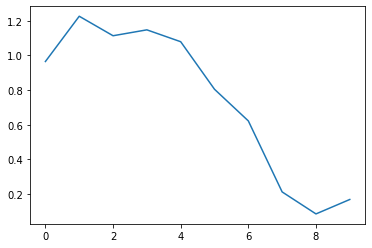

In [20]:
plt.plot(heads)
plt.show()